In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions

The command to kill all spark session, before you start a new one. 
I got error message like:
__Another instance of Derby may have already booted the database /Users/jessie/Desktop/MusicBox/metastore_db.__
```shell
ps -ef | grep spark-shell
kill -9 Spark-Shell-processID ( example: kill -9 4848)
```

To inspect the first 10 lines of a large text file:
```shell
head -n 10 all_play.log.fn
```
I found that the first two lines of "data/all_play.log.fn" is bad formated. So use the following command to delete them:
```shell

```

In [2]:
#Create a SparkSession
spark = SparkSession.builder.appName("ReadingData").getOrCreate()

In [3]:
lines = spark.sparkContext.textFile("data/all_play.log.fn")

In [4]:
from pyspark.sql.types import *

def parseLine(line):
    fields = line.split('\t')
    if len(fields) == 10:
        try:
            uid = float(fields[0])
            device = str(fields[1])
            song_id = str(fields[2])
            song_type = float(fields[3])
            song_name = str(fields[4])
            singer = str(fields[5])
            play_time = str(fields[6])
            song_length = float(fields[7])
            paid_flag = float(fields[8])
            fn = str(fields[9])
            return Row(uid, device, song_id, song_type, song_name, singer, play_time, song_length, paid_flag, fn)
        except:
            return Row(None)
    else:
        return Row(None)


schema = StructType([StructField('uid', FloatType(), False),
                     StructField('device', StringType(), True),
                     StructField('song_id', StringType(), False),
                     StructField('song_type', FloatType(), True),
                     StructField('song_name', StringType(), True),
                     StructField('singer', StringType(), True),
                     StructField('play_time', StringType(), False),
                     StructField('song_length', FloatType(), True),
                     StructField('paid_flag', FloatType(), True),
                     StructField('fn', StringType(), True),])

if you want to create an empty dataframe with RDD:
```python
from pyspark.sql.types import *
field = [StructField(“FIELDNAME_1”,StringType(), True),StructField(“FIELDNAME_2”, StringType(), True),\
 StructField(“FIELDNAME_3”, StringType(), True)]
schema = StructType(field)
df = sqlContext.createDataFrame(sc.emptyRDD(), schema)
```

In [5]:
songs = lines.map(parseLine).filter(lambda x: len(x) == len(schema))
# Convert that to a DataFrame
songDataset = spark.createDataFrame(songs,schema).cache()
#df = spark.read.csv("data/all_play.log.fn",header=False,schema=schema)           

In [6]:
songDataset.show()

+------------+------+---------+---------+--------------------+--------------------+---------+-----------+---------+------------------+
|         uid|device|  song_id|song_type|           song_name|              singer|play_time|song_length|paid_flag|                fn|
+------------+------+---------+---------+--------------------+--------------------+---------+-----------+---------+------------------+
|1.54422688E8|   ar |20870993 |      1.0|                 用情 |              狮子合唱团 |   22013 |      332.0|      0.0| 20170301_play.log|
|1.54421904E8|   ip | 6560858 |      0.0|             表情不要悲伤 |    伯贤&D.O.&张艺兴&朴灿烈 |      96 |      161.0|      0.0| 20170301_play.log|
|1.54422624E8|   ar | 3385963 |      1.0|Baby, Don't Cry(人...|                EXO |  235868 |      235.0|      0.0| 20170301_play.log|
|1.54410272E8|   ar | 6777172 |      0.0|   3D-环绕音律1(3D Mix) |             McTaiM |     164 |      237.0|      0.0| 20170301_play.log|
|1.54407792E8|   ar |19472465 |      0.0|              

In [48]:
# the following command takes lots of time
#songDataset.describe().show()

+-------+--------------------+---------+--------------------+-------------------+---------+--------------------+-------------------+------------------+---------+--------------------+
|summary|                 uid|   device|             song_id|          song_type|song_name|              singer|          play_time|       song_length|paid_flag|                  fn|
+-------+--------------------+---------+--------------------+-------------------+---------+--------------------+-------------------+------------------+---------+--------------------+
|  count|           164264529|164264529|           164264529|          164264529|164264529|           164264529|          164264529|         164264529|164264529|           164264529|
|   mean|1.3238275802376163E8|     null|1.233773654943951...|0.14990355586749954| Infinity|2.069222247928341...| 204343.58310764717|-66.93764578220485|      0.0|                null|
| stddev|6.4977108791913636E7|     null|3.724137957677398...| 0.3858627542831314|    

In [47]:
#songDataset.count()

164264529

In [51]:
songDataset.filter(songDataset.fn.isNotNull()).count()

164264529

## Filter the abnormal users (e.g. robot)

In [9]:
uid_count = songDataset.groupBy('uid').count().orderBy('count', ascending = False).cache()#.show(truncate=False)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# the `histogram` function from the RDD api
log_count_histogram = uid_count.select('count').rdd.flatMap(lambda x: np.log(x)).histogram(11)

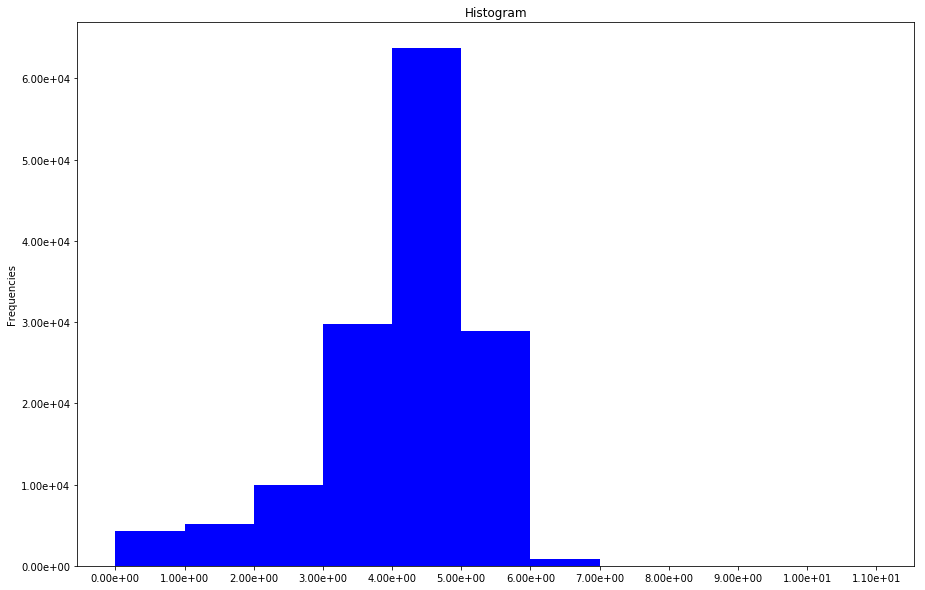

In [23]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
import pandas as pd
import matplotlib.pyplot as mplt
import matplotlib.ticker as mtick

def plotHistogramData(data):
    binSides, binCounts = data

    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = mplt.subplots(figsize=(15,10))
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')

    ax.set_ylabel('Frequencies')
    ax.set_title('Histogram')
    ax.set_xticks(np.arange(N+1))
    ax.set_xticklabels(binSides)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

    mplt.show()
    

plotHistogramData(log_count_histogram)

In [24]:
log_count_histogram

([0.0,
  1.446398381011583,
  2.892796762023166,
  4.3391951430347486,
  5.7855935240463321,
  7.2319919050579156,
  8.6783902860694973,
  10.124788667081081,
  11.571187048092664,
  13.017585429104248,
  14.463983810115831,
  15.910382191127413],
 [4269, 5150, 9898, 29739, 63734, 28950, 895, 19, 6, 6, 6])

In [50]:
print('total number of unique users: ', uid_count.count(),
     '\n approximate quantile is : ', np.exp(8.6783902860694973))

total number of unique users:  142672 
 approximate quantile is :  5874.58257879


In [51]:
# calculate the 90 percent quatile
uid_count.approxQuantile("count", [0.95], 0)

[2975.0]

### Generate valid user list

In [66]:
uid_count.printSchema()
valid_list = uid_count.filter( uid_count['count'] <= 2975.0).toPandas()

root
 |-- uid: float (nullable = false)
 |-- count: long (nullable = false)



In [70]:
print('valid user number = ', valid_list.shape[0])
print('saving valid user id... ')
valid_list.to_csv('data/valid_user_id.csv', index=False)

valid user number =  135549
saving valid user id... 


### Generate Filtered 'all_play_log"

In [6]:
#import pandas as pd
#valid_list = pd.read_csv('data/valid_user_id.csv')
u_list = list(valid_list.uid.values)
filtered_all_play = songDataset.drop('song_type', 'song_name', 'singer', 'paid_flag').filter(songDataset['uid'].isin(u_list)).cache()

In [77]:
filtered_all_play.count()

98396373

In [ ]:
print('saving filtered all play log!')

filtered_all_play.write.mode('append').json('data/filtered_all_play.json')
#filtered_all_play.coalesce(1).write.csv("/data/filtered_all_play.csv")

saving filtered all play log!


In [ ]:
spark.stop()